In [1]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional 

2022-12-12 13:03:03.150494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[Predicting Sequential Data using LSTM: An Introduction](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

In [2]:
huwaei=pd.read_csv('training_100.csv')
huwaei['timestamp']=pd.to_datetime(huwaei['timestamp'])

In [3]:
huwaei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20159 entries, 0 to 20158
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype                                
---  ------         --------------  -----                                
 0   timestamp      20159 non-null  datetime64[ns, pytz.FixedOffset(120)]
 1   kpi_value      20159 non-null  float64                              
 2   request_count  20159 non-null  int64                                
 3   anomaly_label  20159 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(120)](1), float64(1), int64(2)
memory usage: 630.1 KB


In [4]:
huwaei.head() 

,timestamp,kpi_value,request_count,anomaly_label
0,2020-08-14 02:00:00+02:00,0.998755,24908,0
1,2020-08-14 02:01:00+02:00,0.997683,25029,0
2,2020-08-14 02:02:00+02:00,0.998341,24115,0
3,2020-08-14 02:03:00+02:00,0.998211,24031,0
4,2020-08-14 02:04:00+02:00,0.998403,23790,0


In [5]:
huwaei.tail()

,timestamp,kpi_value,request_count,anomaly_label
20154,2020-08-28 01:56:00+02:00,0.998149,26467,0
20155,2020-08-28 01:57:00+02:00,0.998340,26502,0
20156,2020-08-28 01:58:00+02:00,0.998364,26887,0
20157,2020-08-28 01:59:00+02:00,0.998428,26712,0
20158,2020-08-28 02:00:00+02:00,0.997407,29694,0


In [6]:
kpi=huwaei['kpi_value']
timestamp=huwaei['timestamp']
label=huwaei['anomaly_label']

Text(0.5, 1.0, 'Huwaei Dataset')

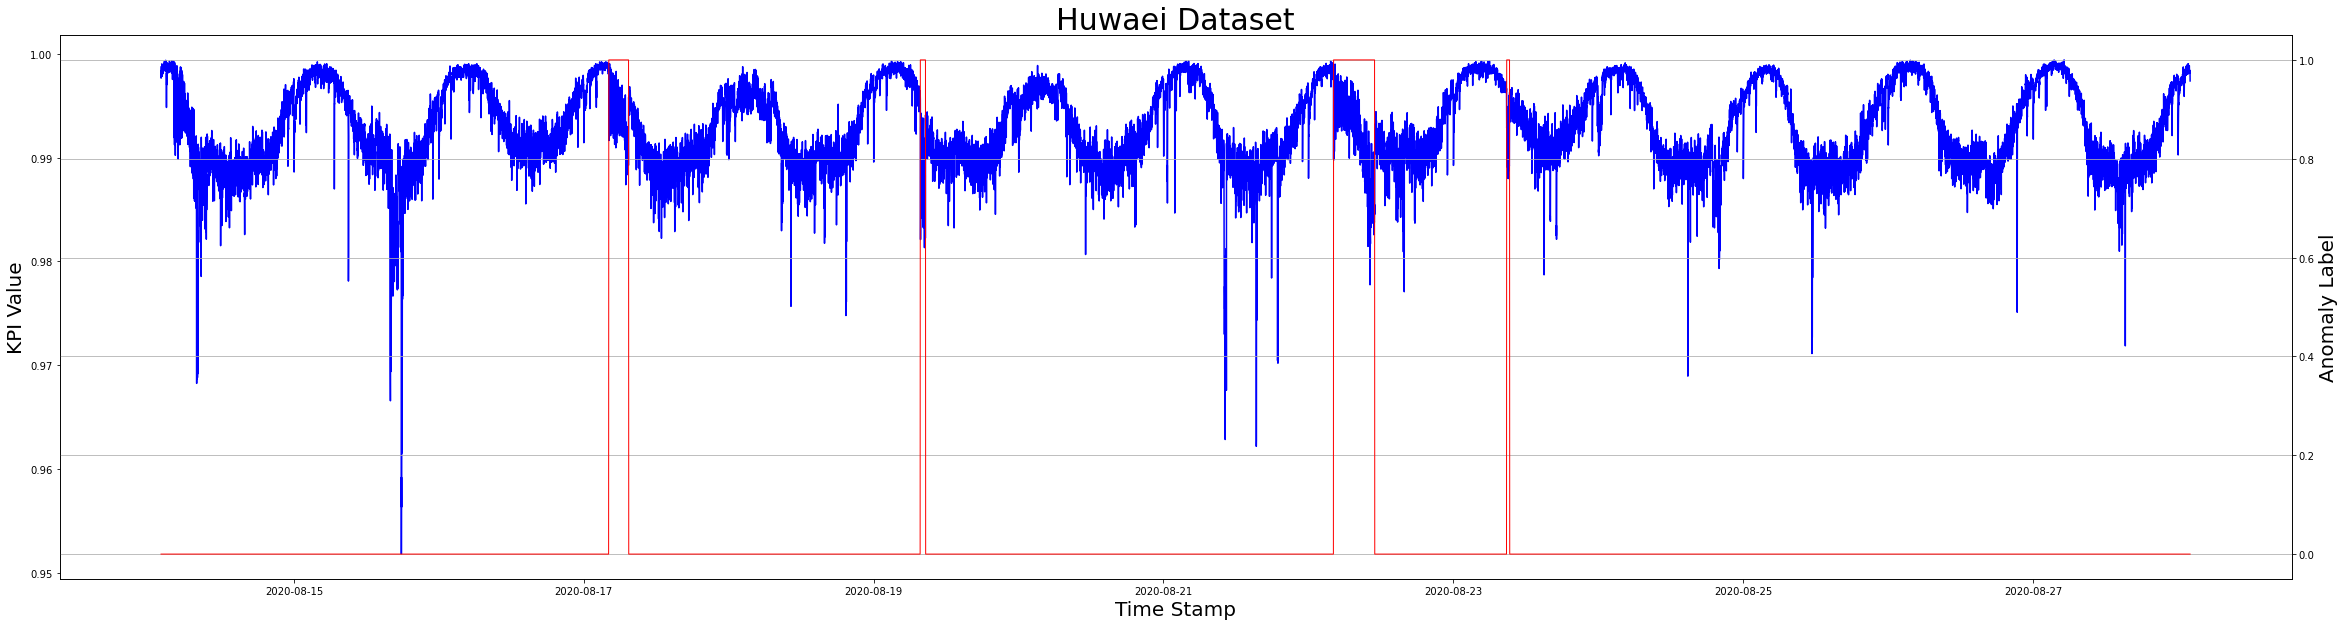

In [7]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, kpi, color='blue')
ax2a.plot(timestamp, label, color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

In [8]:
timestamp
arr=np.where(timestamp=='2020-08-24 00:00:00+02:00')
arr

(array([14280]),)

In [9]:
split1=timestamp[4200]
split2=timestamp[4800]
split3=timestamp[7080]
split4=timestamp[7680]
split5=timestamp[11400]
split6=timestamp[14280]

Start date is:  2020-08-14 02:00:00+02:00
End date is:  2020-08-28 02:00:00+02:00
Length of full data: 20159


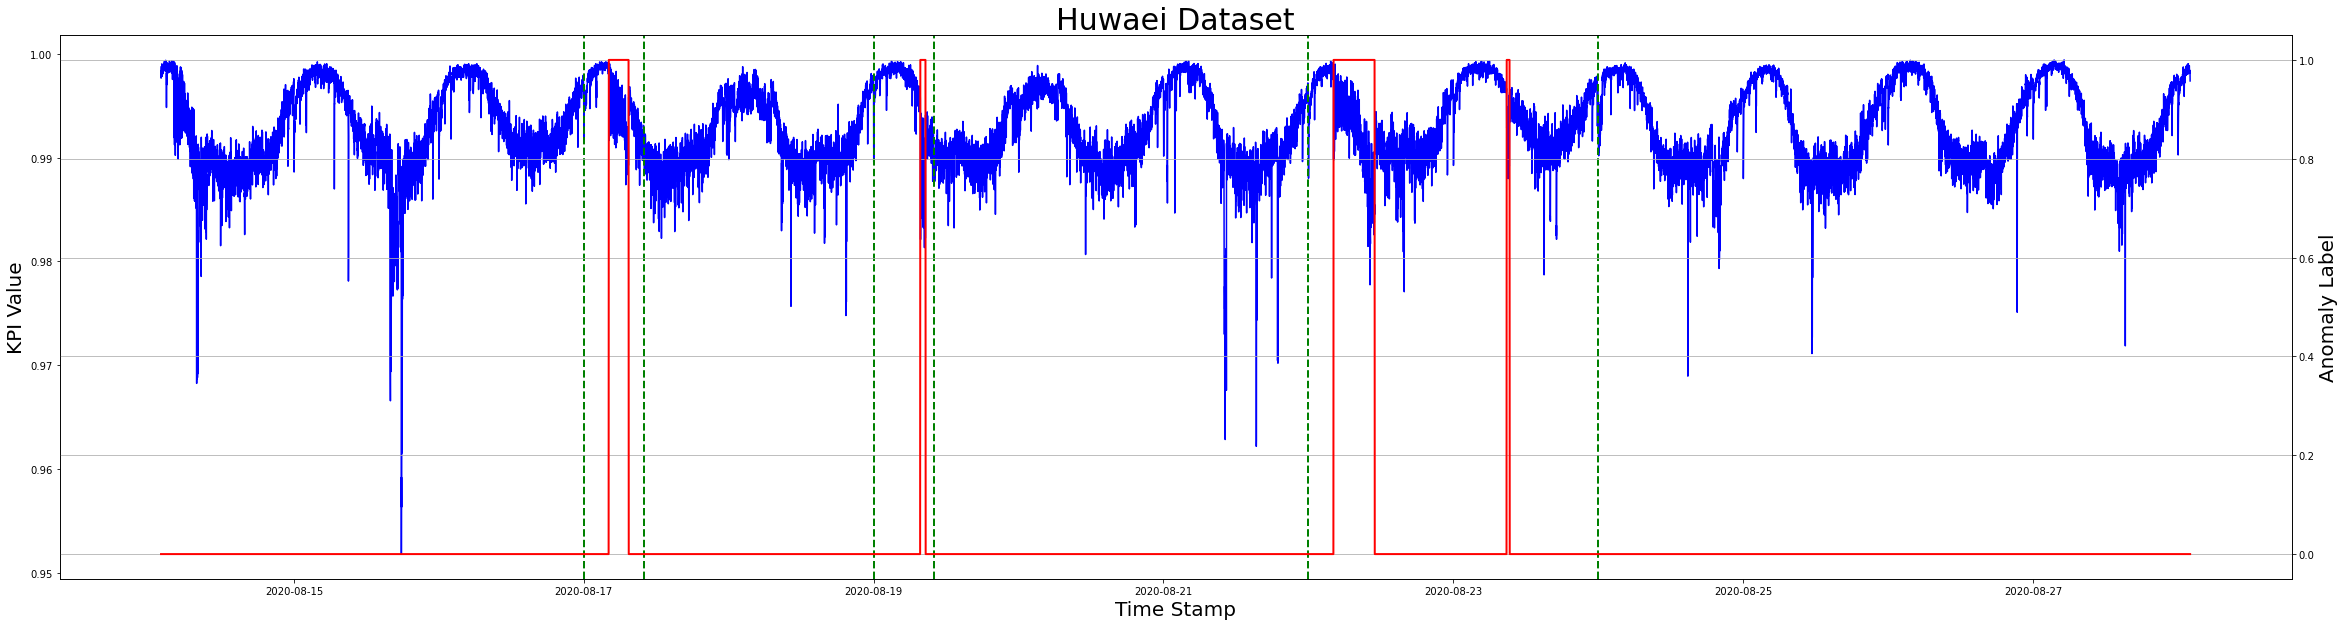

In [10]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, kpi, color='blue')
ax2a.plot(timestamp, label, color='red', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6, color='green', linestyle='dashed', linewidth='2')


plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

print("Start date is: ", timestamp.min())
print("End date is: ", timestamp.max())
print(f"Length of full data: {len(huwaei)}")

In [11]:
splits=[split1, split2, split3, split4, split5, split6]
splits

[Timestamp('2020-08-17 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-17 10:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-19 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-19 10:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-22 00:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-24 00:00:00+0200', tz='pytz.FixedOffset(120)')]

In [12]:
# Training intervals
train1 = huwaei.loc[timestamp <= splits[0]]

train2 = huwaei.loc[(timestamp > splits[1]) & (timestamp <= splits[2])]

train3 = huwaei.loc[(timestamp > splits[3]) & (timestamp <= splits[4])]

train4 = huwaei.loc[timestamp > splits[5]]


# Testing intervals
test1 = huwaei.loc[(timestamp > splits[0]) & (timestamp <= splits[1])]

test2 = huwaei.loc[(timestamp > splits[2]) & (timestamp <= splits[3])]

test3 = huwaei.loc[(timestamp > splits[4]) & (timestamp <= splits[5])]

Text(0.5, 1.0, 'Huwaei Dataset')

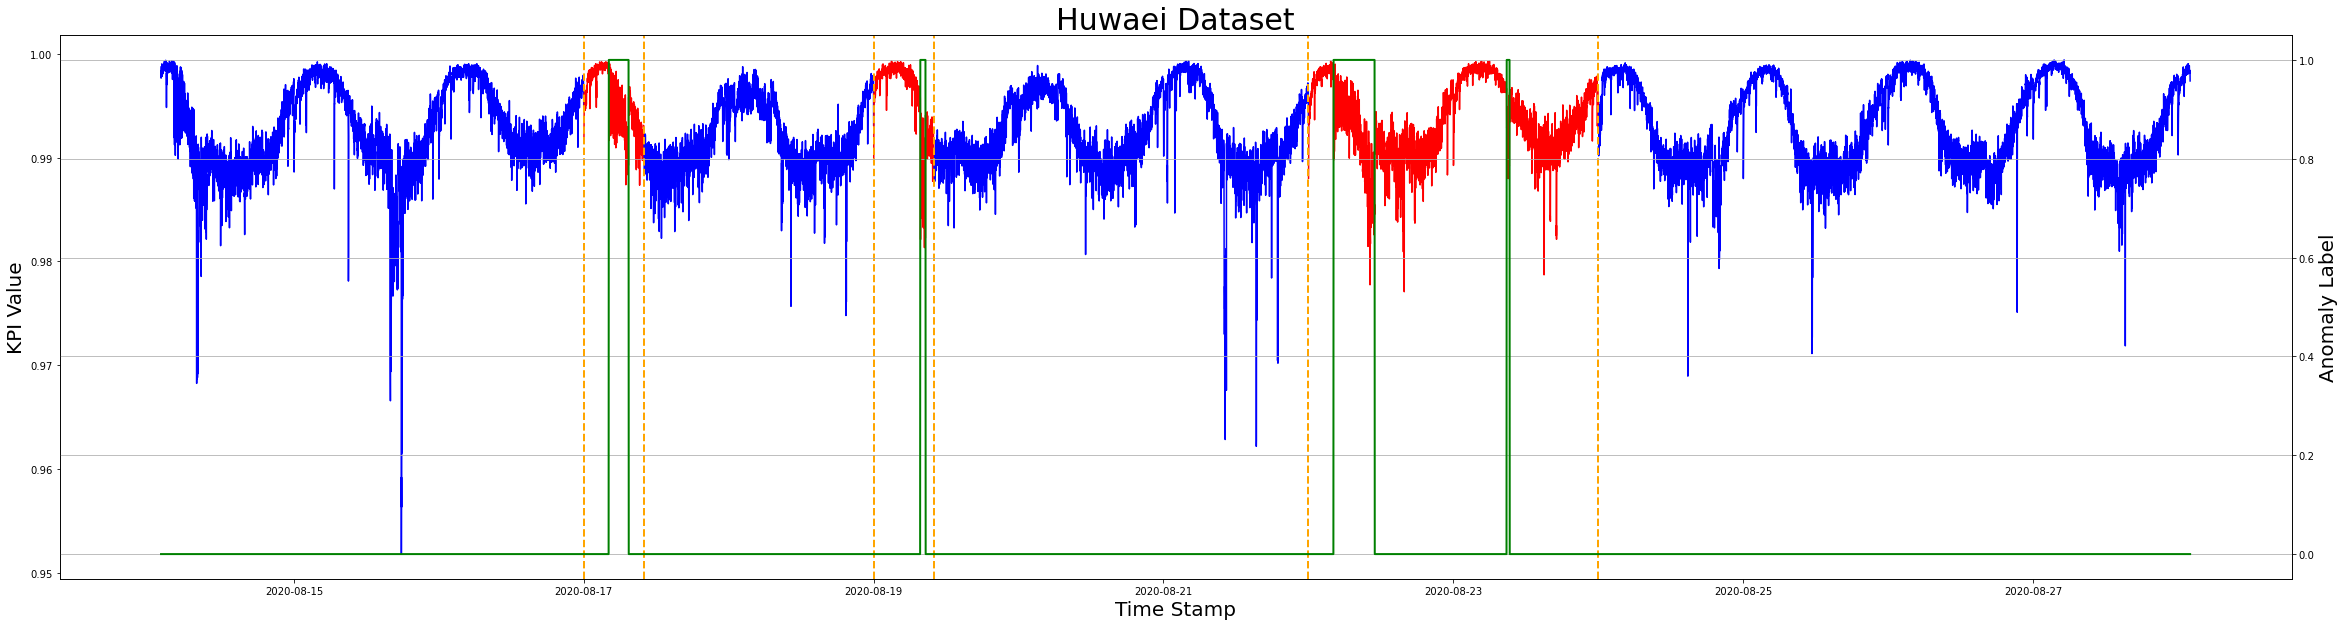

In [13]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(train1['timestamp'], train1['kpi_value'], color='blue')
ax2d.plot(test1['timestamp'], test1['kpi_value'], color='red')
ax2d.plot(train2['timestamp'], train2['kpi_value'], color='blue')
ax2d.plot(test2['timestamp'], test2['kpi_value'], color='red')
ax2d.plot(train3['timestamp'], train3['kpi_value'], color='blue')
ax2d.plot(test3['timestamp'], test3['kpi_value'], color='red')
ax2d.plot(train4['timestamp'], train4['kpi_value'], color='blue')
ax2a.plot(timestamp, label, color='green', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split2, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split3, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split4, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split5, color='orange', linestyle='dashed', linewidth='2')
ax2d.axvline(split6, color='orange', linestyle='dashed', linewidth='2')

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

In [14]:
# Preprocessing: normalize the data in mean and variance
scaler = StandardScaler()
scaler = scaler.fit(pd.concat([train1, train2, train3, train4])[['kpi_value', 'request_count']]) #To normalize the mean and variance

train1[['kpi_value', 'request_count']] = scaler.transform(train1[['kpi_value', 'request_count']])
train2[['kpi_value', 'request_count']] = scaler.transform(train2[['kpi_value', 'request_count']])
train3[['kpi_value', 'request_count']] = scaler.transform(train3[['kpi_value', 'request_count']])
train4[['kpi_value', 'request_count']] = scaler.transform(train4[['kpi_value', 'request_count']])

trainSeqs = [train1, train2, train3, train4]

# Avoid leakage of information between train and test dataset

test1[['kpi_value', 'request_count']] = scaler.transform(test1[['kpi_value', 'request_count']])
test2[['kpi_value', 'request_count']] = scaler.transform(test2[['kpi_value', 'request_count']])
test3[['kpi_value', 'request_count']] = scaler.transform(test3[['kpi_value', 'request_count']])

testSeqs = [test1, test2, test3]

In [15]:
# Compute the train to test ratio

learn_ratio = pd.concat(trainSeqs).shape[0] / huwaei.shape[0]
print("Training dataset percentage: " "{:.2f}" "%".format(learn_ratio*100))

test_ratio = pd.concat(testSeqs).shape[0] / huwaei.shape[0]
print("Testing dataset percentage: " "{:.2f}" "%".format(test_ratio*100))

Training dataset percentage: 79.76%
Testing dataset percentage: 20.24%


In [16]:
trainSeqs

[                     timestamp  kpi_value  request_count  anomaly_label
 0    2020-08-14 02:00:00+02:00   1.508552       1.765505              0
 1    2020-08-14 02:01:00+02:00   1.243159       1.783991              0
 2    2020-08-14 02:02:00+02:00   1.406095       1.644353              0
 3    2020-08-14 02:03:00+02:00   1.373775       1.631520              0
 4    2020-08-14 02:04:00+02:00   1.421287       1.594701              0
 ...                        ...        ...            ...            ...
 4196 2020-08-16 23:56:00+02:00   1.164309       1.031870              0
 4197 2020-08-16 23:57:00+02:00   1.160132       1.069912              0
 4198 2020-08-16 23:58:00+02:00   1.081624       0.943412              0
 4199 2020-08-16 23:59:00+02:00   1.086746       0.860760              0
 4200 2020-08-17 00:00:00+02:00   0.492590       9.208951              0
 
 [4201 rows x 4 columns],
                      timestamp  kpi_value  request_count  anomaly_label
 4801 2020-08-17 10:01:

In [17]:
testSeqs

[                     timestamp  kpi_value  request_count  anomaly_label
 4201 2020-08-17 00:01:00+02:00  -0.298217       4.215895              0
 4202 2020-08-17 00:02:00+02:00  -0.174642       2.022476              0
 4203 2020-08-17 00:03:00+02:00   0.387258       1.556812              0
 4204 2020-08-17 00:04:00+02:00   0.446124       1.490659              0
 4205 2020-08-17 00:05:00+02:00   0.582078       1.358966              0
 ...                        ...        ...            ...            ...
 4796 2020-08-17 09:56:00+02:00  -0.072083      -0.438761              0
 4797 2020-08-17 09:57:00+02:00  -0.350213      -0.522177              0
 4798 2020-08-17 09:58:00+02:00  -0.672569      -0.582065              0
 4799 2020-08-17 09:59:00+02:00  -0.563406      -0.626371              0
 4800 2020-08-17 10:00:00+02:00  -0.304437      -0.418136              0
 
 [600 rows x 4 columns],
                      timestamp  kpi_value  request_count  anomaly_label
 7081 2020-08-19 00:01:0

In [18]:
# TIME_STEPS = 28 #Could change the timesteps default=32
# sample_predict=1

# # Create the sequences of size TIME_STEPS to feed the sequential model
# def to_sequences(x, y, TIME_STEPS=1):
#     x_values = []
#     y_values = []

#     for i in range(len(x)-TIME_STEPS):
#         x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
#         y_values.append(y.iloc[i+sample_predict:(i+TIME_STEPS+sample_predict)].values)
        
#     return np.array(x_values), np.array(y_values)

# # Stack the sequences obtained in each period to create a single training tensor
# trainX = np.array([])
# trainY = np.array([])
# testX = np.array([])
# testY = np.array([])

# for train in trainSeqs:
#     x, y = to_sequences(train[['kpi_value']], train[['kpi_value']], TIME_STEPS)
#     trainX = np.vstack([trainX, x]) if trainX.size else x
#     trainY = np.vstack([trainY, y]) if trainY.size else y
    
# for test in testSeqs:
#     x, y = to_sequences(test[['kpi_value']], test[['kpi_value']], TIME_STEPS)
#     testX = np.vstack([testX, x]) if testX.size else x
#     testY = np.vstack([testY, y]) if testY.size else y

In [19]:
TIME_STEPS = 30 #Could change the timesteps default=32

# Create the sequences of size TIME_STEPS to feed the sequential model for the input
def to_sequences_Input(x, TIME_STEPS=1):
    x_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
        
    return np.array(x_values)

# Create the sequences of size TIME_STEPS to feed the sequential model for the output
def to_sequences_Output(y, TIME_STEPS=1):
    y_values = []

    for i in range(len(y)-TIME_STEPS):
        y_values.append(y[i:(i+TIME_STEPS)])
        
    return np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x = to_sequences_Input(train[['kpi_value','request_count']], TIME_STEPS)
    y = to_sequences_Output(train['kpi_value'], TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x = to_sequences_Input(test[['kpi_value','request_count']], TIME_STEPS)
    y = to_sequences_Output(test['kpi_value'], TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [20]:
print(f"Train X shape: {trainX.shape[0]} batches, {trainX.shape[1]} values for each batch, {trainX.shape[2]} dimensional batches")
print(f"Train Y shape: {trainY.shape[0]} batches, {trainY.shape[1]} values for each batch, 1 dimensional batch")
print(f"Test X shape: {testX.shape[0]} batches, {testX.shape[1]} values for each batch, {testX.shape[2]} dimensional batches")
print(f"Test Y shape: {testY.shape[0]} batches, {testY.shape[1]} values for each batch, 1 dimensional batch")
# 15951 + 3984 + (32*7) = 20159
# 32 values for each sample
# 3984 testing batches

Train X shape: 15959 batches, 30 values for each batch, 2 dimensional batches
Train Y shape: 15959 batches, 30 values for each batch, 1 dimensional batch
Test X shape: 3990 batches, 30 values for each batch, 2 dimensional batches
Test Y shape: 3990 batches, 30 values for each batch, 1 dimensional batch


In [21]:
# print(trainX[0])
# print("")
# print(trainX[1])

In [22]:
# print(trainX[0])
# print("")
# print(trainY[0])

# Creating the Neural Network

In [23]:
model = Sequential()
model.add(layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(layers.Dropout(rate=0.2))

model.add(layers.RepeatVector(trainX.shape[1]))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(optimizer='adam', loss='mae')
model.summary()

2022-12-12 13:03:15.442732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [24]:
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

Epoch 1/50
449/449 [==============================] - 29s 60ms/step - loss: 0.2620 - val_loss: 0.1898
Epoch 2/50
449/449 [==============================] - 26s 57ms/step - loss: 0.2330 - val_loss: 0.1744
Epoch 3/50
449/449 [==============================] - 26s 59ms/step - loss: 0.2256 - val_loss: 0.1713
Epoch 4/50
449/449 [==============================] - 31s 69ms/step - loss: 0.2210 - val_loss: 0.1666
Epoch 5/50
449/449 [==============================] - 35s 78ms/step - loss: 0.2185 - val_loss: 0.1668
Epoch 6/50
449/449 [==============================] - 37s 82ms/step - loss: 0.2146 - val_loss: 0.1707
Epoch 7/50
449/449 [==============================] - 41s 91ms/step - loss: 0.2125 - val_loss: 0.1590
Epoch 8/50
449/449 [==============================] - 41s 91ms/step - loss: 0.2108 - val_loss: 0.1605
Epoch 9/50
449/449 [==============================] - 38s 84ms/step - loss: 0.2088 - val_loss: 0.1568
Epoch 10/50
449/449 [==============================] - 42s 93ms/step - loss: 0.206

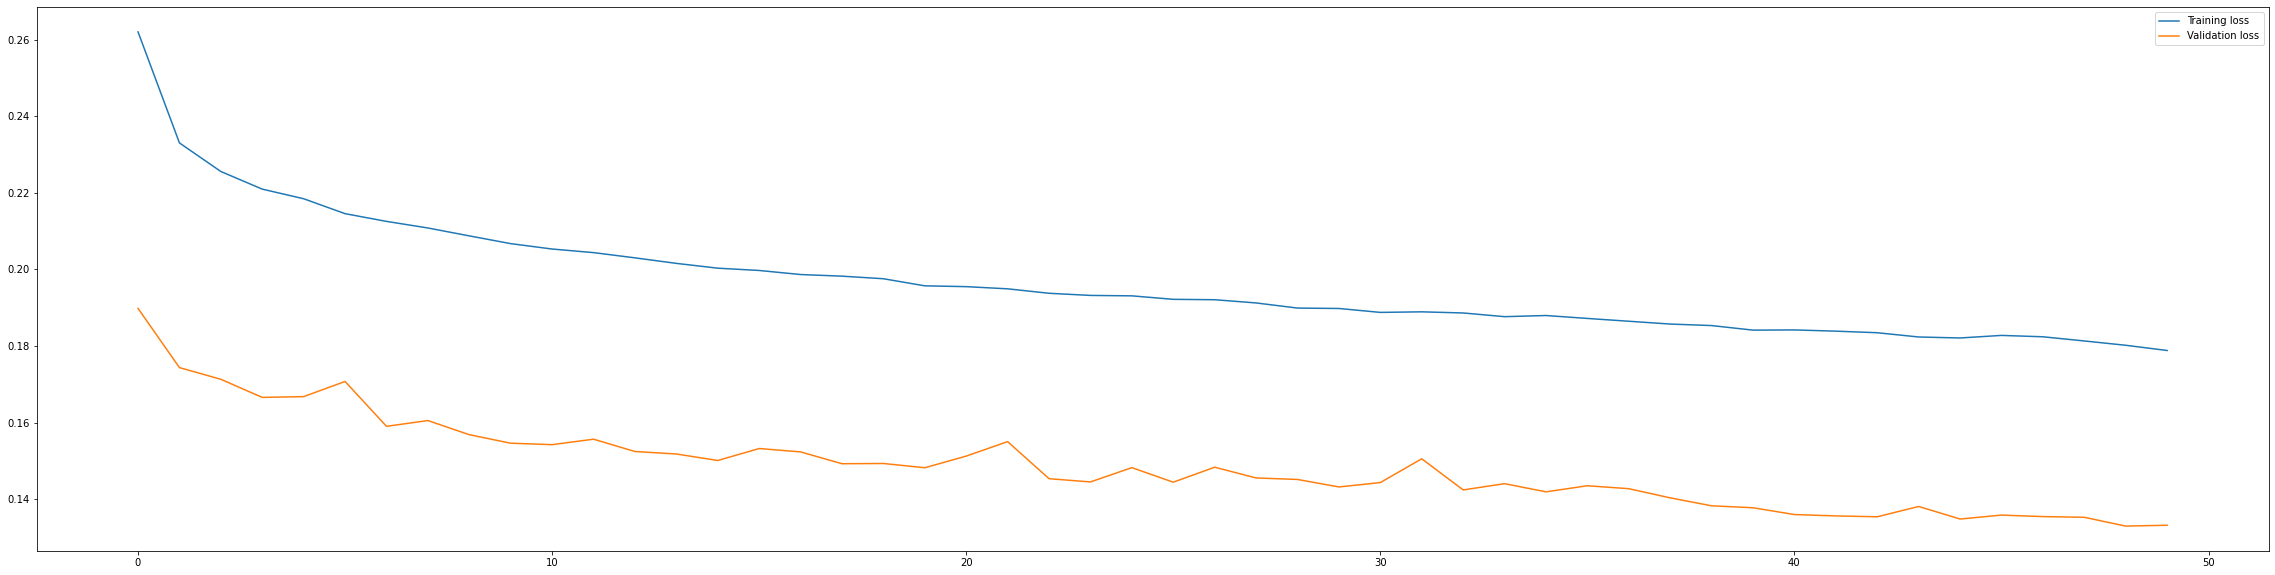

In [25]:
# Plot the training and validation loss 
plt.figure(figsize=(40,10))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

499/499 [==============================] - 21s 41ms/step
Train Predict Shape (15959, 30)
Train Y Shape (15959, 30)


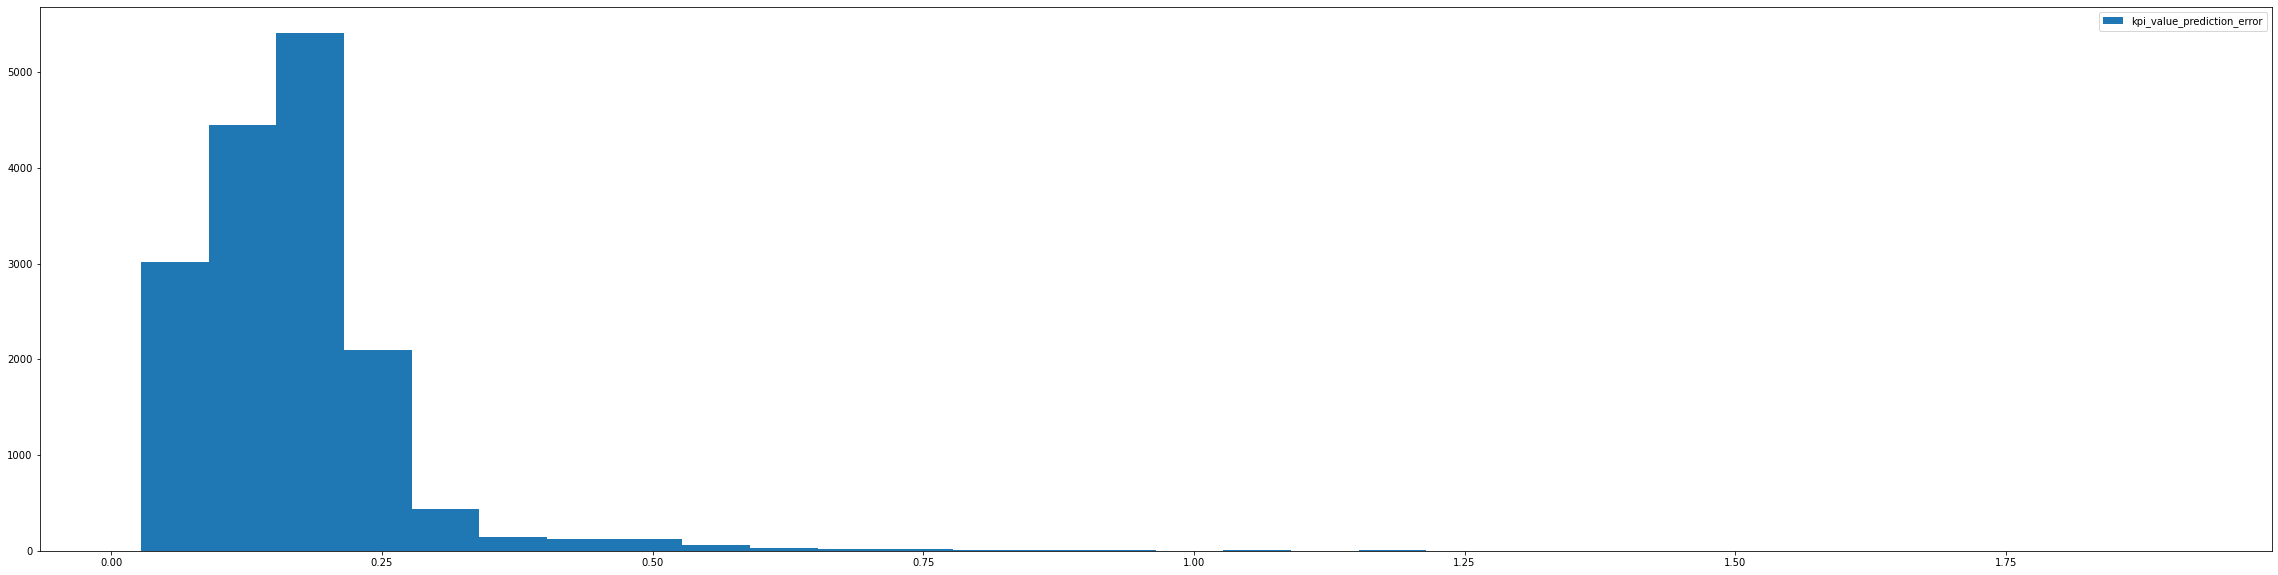

In [26]:
# Plot a histogram of the reconstruction error in the training dataset to decide a threshold

trainPredict = model.predict(trainX)
print(f"Train Predict Shape {(trainPredict.squeeze()).shape}")
print(f"Train Y Shape {trainY.shape}")
trainMAE = np.mean(np.abs((trainPredict.squeeze()) - trainY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(trainMAE, bins=30);
plt.legend(['kpi_value_prediction_error'])
threshold_trainMAE = 0.30  #or Define 90% value of max as threshold.

125/125 [==============================] - 5s 44ms/step


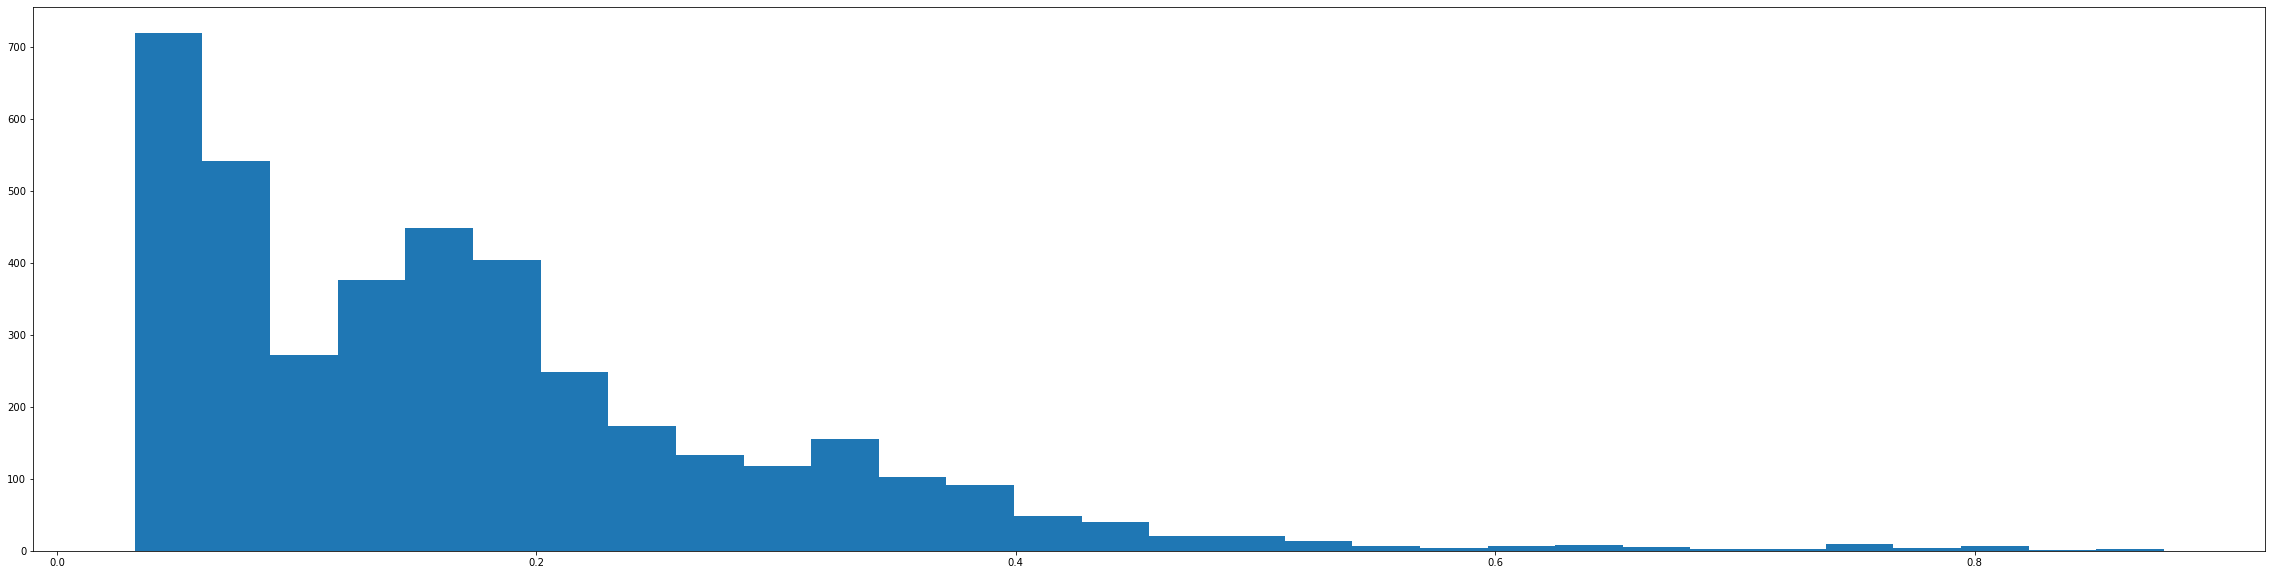

In [27]:
# Histogram of the testing MAE
testPredict = model.predict(testX)
testMAE = np.mean(np.abs((testPredict.squeeze()) - testY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(testMAE, bins=30);

In [28]:
# Detect anomaly if the reconstruction loss for a sample is greater than the threshold

anomaly_df = pd.concat([seq[TIME_STEPS:] for seq in testSeqs])
anomaly_df['testMAE'] = testMAE
anomaly_df['threshold_trainMAE'] = threshold_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['threshold_trainMAE']

In [29]:
# plt.figure(figsize=(40,10))
# for i in range(trainPredict.shape[0]):
#     plt.plot(trainPredict[i])

In [30]:
# plt.figure(figsize=(40,10))
# for i in range(testPredict.shape[0]):
#     plt.plot(testPredict[i])

In [31]:
testPredict.shape[0]

3990

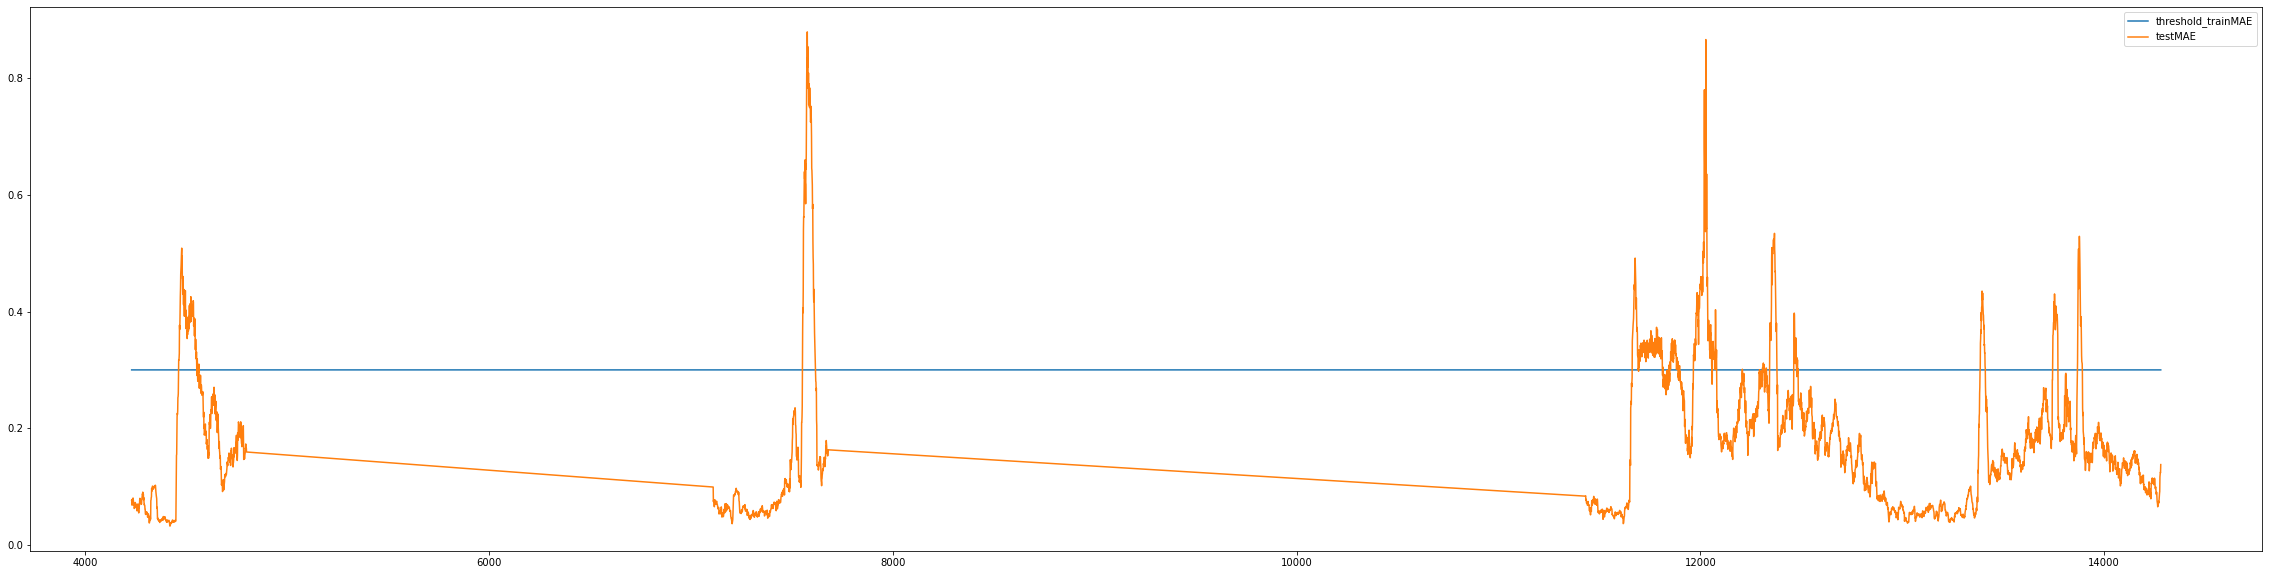

In [32]:
# Plot the test MAE
plt.figure(figsize=[40, 10])
anomaly_df['threshold_trainMAE'].plot()
anomaly_df['testMAE'].plot()
plt.legend()

In [33]:
# Detect the anomaly points inside the dataset
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

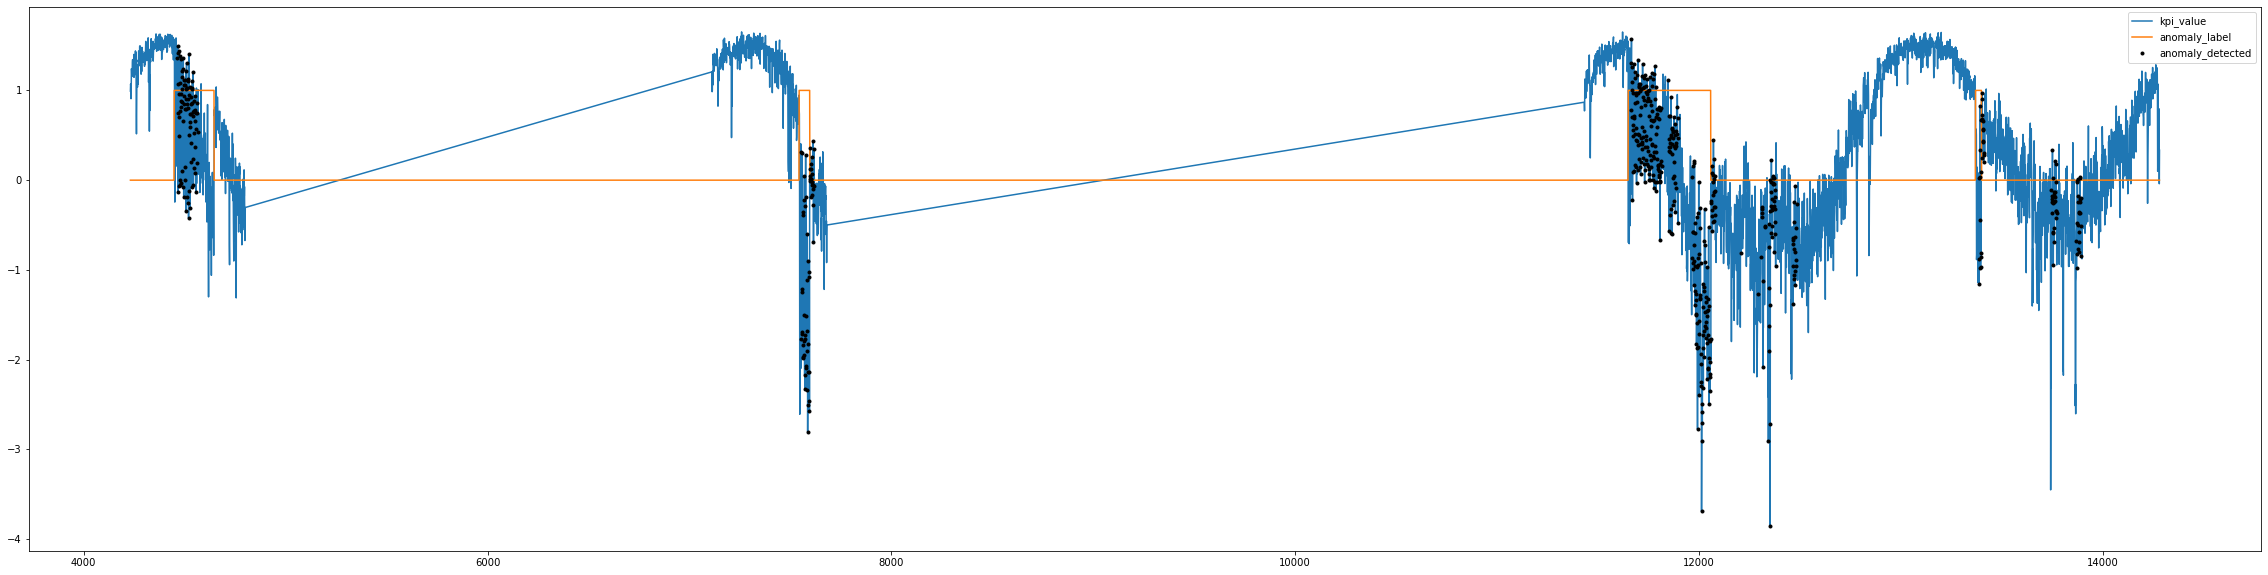

In [34]:
#Plot the anomalies
plt.figure(figsize=(40,10))
anomaly_df['kpi_value'].plot()
anomaly_df['anomaly_label'].plot()
anomalies['kpi_value'].plot(marker='.', linestyle='None', label='anomaly_detected', color='black')
plt.legend()

In [35]:
# Inspect the resulting dataset
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 4231 to 14280
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype                                
---  ------              --------------  -----                                
 0   timestamp           3990 non-null   datetime64[ns, pytz.FixedOffset(120)]
 1   kpi_value           3990 non-null   float64                              
 2   request_count       3990 non-null   float64                              
 3   anomaly_label       3990 non-null   int64                                
 4   testMAE             3990 non-null   float64                              
 5   threshold_trainMAE  3990 non-null   float64                              
 6   anomaly             3990 non-null   bool                                 
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(120)](1), float64(4), int64(1)
memory usage: 222.1 KB


In [36]:
anomaly_df

,timestamp,kpi_value,request_count,anomaly_label,testMAE,threshold_trainMAE,anomaly
4231,2020-08-17 00:31:00+02:00,0.991987,1.260883,0,0.076803,0.3,False
4232,2020-08-17 00:32:00+02:00,1.070022,1.302133,0,0.077935,0.3,False
4233,2020-08-17 00:33:00+02:00,1.046498,1.249119,0,0.068207,0.3,False
4234,2020-08-17 00:34:00+02:00,0.907252,1.161120,0,0.070561,0.3,False
4235,2020-08-17 00:35:00+02:00,1.017913,1.226050,0,0.075950,0.3,False
...,...,...,...,...,...,...,...
14276,2020-08-23 23:56:00+02:00,0.106058,1.186481,0,0.116621,0.3,False
14277,2020-08-23 23:57:00+02:00,0.795930,1.293424,0,0.119938,0.3,False
14278,2020-08-23 23:58:00+02:00,0.695386,1.230480,0,0.124428,0.3,False
14279,2020-08-23 23:59:00+02:00,-0.039992,1.115898,0,0.123849,0.3,False


In [37]:
# Compute the precision in the test dataset
precision=precision_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"Precision: {round(precision, 3)}")
# Compute the recall in the test dataset
recall=recall_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"Recall: {round(recall, 3)}")
# Compute the F1 score in the test dataset
f1_score=f1_score(anomaly_df['anomaly_label'], anomaly_df['anomaly'])
print(f"F1 Score: {round(f1_score, 3)}")

Precision: 0.718
Recall: 0.636
F1 Score: 0.675
